<a href="https://colab.research.google.com/github/fabriciosantana/mcdia/blob/main/01-icd/assignments/04-analise-tematica-discursos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classificação em temas dos Discursos do Senado


## Importar bibliotecas

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datasets import load_dataset
from datasets import load_dataset_builder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.svm import LinearSVC

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


## Carregar dados

In [2]:
#DATA_PATH = Path('data/hf_discursos/data/full/discursos_2019-02-01_2023-01-31.parquet')
#df_raw = pd.read_parquet(DATA_PATH)

DATASET_HF_REPO = "fabriciosantana/discursos-senado-legislatura-56"
DATA_FILE_HF = {"train": "data/full/discursos_2019-02-01_2023-01-31.parquet"}

dataset = load_dataset(DATASET_HF_REPO, data_files=DATA_FILE_HF)
df_raw = dataset["train"].to_pandas()

df_raw.head()

,id,CodigoPronunciamento,Casa,Data,Resumo,Indexacao,TextoIntegral,TextoIntegralTxt,UrlTextoBinario,TipoAutor,...,Apartes.Aparteante,__janela_inicio,__janela_fim,CargoAutor,OrgaoAutor,PaisAutor,TextoDiscursoIntegral,ok,status,msg
0,451286,451286,Senado Federal,2019-02-27,Comentários a respeito da concentração bancári...,"COMENTARIO, CONCENTRAÇÃO, REDE BANCARIA, COBRA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
1,451285,451285,Senado Federal,2019-02-27,Registro do impacto da reforma da previdência ...,"REGISTRO, REFORMA, PREVIDENCIA SOCIAL, ALTERAÇ...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,SENADO FEDERAL SF -\nSECRETARIA-GERAL DA MESA\...,True,200,
2,451205,451205,Senado Federal,2019-02-27,Comentários a respeito da catástrofe ocorrida ...,"COMENTARIO, DESASTRE, ROMPIMENTO, BARRAGEM, BR...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. WELLINGTON FAGUNDES (Bloco Parlamentar V...,True,200,
3,451203,451203,Senado Federal,2019-02-27,Expectativa com o início dos trabalhos no âmbi...,"EXPECTATIVA, INICIO, TRABALHO, COMISSÕES, SENA...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. CONFÚCIO MOURA (Bloco Parlamentar Unidos...,True,200,
4,451202,451202,Senado Federal,2019-02-27,Relato da origem e das motivações do Projeto d...,"COMENTARIO, ORIGEM, MOTIVO, PROJETO DE LEI, OB...",https://www25.senado.leg.br/web/atividade/pron...,https://legis.senado.leg.br/dadosabertos/discu...,https://legis.senado.leg.br/dadosabertos/discu...,Senador(a),...,None,2019-02-01,2019-03-03,None,None,None,O SR. RODRIGO PACHECO (Bloco Parlamentar Vangu...,True,200,


## Preparar dados para análise temática

Filtramos colunas relevantes, padronizamos o texto e removemos discursos muito curtos para reduzir ruído.


In [3]:
colunas = ['Data', 'NomeAutor', 'Partido', 'UF', 'TextoDiscursoIntegral']

df = (
    df_raw[colunas]
    .rename(columns={
        'TextoDiscursoIntegral': 'texto',
        'NomeAutor': 'nome_autor'
    })
    .dropna(subset=['texto'])
)

# Limpeza básica do texto e metadados
df['texto'] = df['texto'].str.strip()
df = df[df['texto'].str.len() > 0]
df['Data'] = pd.to_datetime(df['Data'], errors='coerce')
df = df.dropna(subset=['Data'])
df['n_palavras'] = df['texto'].str.split().str.len()
df = df[df['n_palavras'] >= 30]
df = df.sort_values('Data').reset_index(drop=True)

print(f"Discursos após limpeza: {len(df):,}")
df.head()


Discursos após limpeza: 14,481


,Data,nome_autor,Partido,UF,texto,n_palavras
0,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,1134
1,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,1077
2,2019-02-01,Davi Alcolumbre,DEM,AP,O SR. PRESIDENTE (Davi Alcolumbre. DEM - AP) –...,925
3,2019-02-01,Major Olimpio,PSL,SP,O SR. MAJOR OLIMPIO (PSL - SP. Pela ordem.) – ...,184
4,2019-02-01,Weverton,PDT,MA,O SR. WEVERTON ROCHA (PDT - MA. Pela ordem.) –...,498


## Selecionar amostra para acelerar modelagem

O conjunto é reduzido para acelerar a vetorização e a extração de temas sem perder representatividade temporal.


In [4]:
MAX_DISCURSOS = 8000

if len(df) > MAX_DISCURSOS:
    df_modelo = df.sample(MAX_DISCURSOS, random_state=42).sort_values('Data').reset_index(drop=True)
else:
    df_modelo = df.copy()

print(f'Tamanho final da amostra: {len(df_modelo):,}')

df_modelo['Data'].agg(['min', 'max'])


Tamanho final da amostra: 8,000


min   2019-02-01
max   2023-01-10
Name: Data, dtype: datetime64[ns]

## Configurar stop words

In [5]:
stopwords_pt = """
a ao aos as ate com como contra da das de dela dele deles delas dentro depois desde dessa desse desta deste disso do dos e ela elas ele eles em entre essa esse essas esses esta este estou eu foi ha isso ja la mais mas mesmo mesma meus minhas na nas nem no nos nossa nosso nossas nossos ou para pela pelas pelo pelos perante pois por porque qual quando que quem se sem ser sob sobre sua suas tambem tem tendo tera teve todos todo um uma umas uns vai ver voce voces
""".split()

stopwords_pt = sorted(set(stopwords_pt))
len(stopwords_pt)


96

## Realizar vetorização com TF-IDF

Transformamos os discursos em vetores de características, preservando unigramas e bigramas frequentes.


In [7]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=20000,
    min_df=25,
    max_df=0.6,
    ngram_range=(1, 2),
    stop_words=stopwords_pt,
    strip_accents='unicode'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo['texto'])

print('Dimensões da matriz TF-IDF:', tfidf_matrix.shape)


Dimensões da matriz TF-IDF: (8000, 18944)


## Descobrir temas com NMF

Aplicamos NMF (Non-negative Matrix Factorization) para captar padrões latentes de vocabulário que sugerem temas.


In [8]:
N_TEMAS = 8

nmf_model = NMF(
    n_components=N_TEMAS,
    random_state=42,
    init='nndsvda',
    max_iter=400
)

W = nmf_model.fit_transform(tfidf_matrix)
H = nmf_model.components_

print('Matriz W (documentos x temas):', W.shape)
print('Matriz H (temas x termos):', H.shape)


Matriz W (documentos x temas): (8000, 8)
Matriz H (temas x termos): (8, 18944)


## Analisar principais termos por tema

Listamos as palavras com maior peso em cada tema para auxiliar na interpretação semântica.


In [9]:
def extrair_top_termos(modelo, feature_names, top_n=12):
    registros = []
    for idx, topic in enumerate(modelo.components_):
        top_indices = topic.argsort()[::-1][:top_n]
        termos = [feature_names[i] for i in top_indices]
        registros.append({
            'tema_id': idx,
            'termos': termos,
            'principais_termos': ', '.join(termos[:10])
        })
    return pd.DataFrame(registros)

feature_names = tfidf_vectorizer.get_feature_names_out()
temas_df = extrair_top_termos(nmf_model, feature_names)
temas_df['tema_label'] = temas_df['termos'].apply(lambda termos: ' / '.join(termos[:3]))

# Visualiza termos chave por tema
temas_df[['tema_id', 'tema_label', 'principais_termos']]


,tema_id,tema_label,principais_termos
0,0,gente / governo / pais,"gente, governo, pais, sao, temos, ter, pessoas..."
1,1,parlamentar unidos / unidos brasil / unidos,"parlamentar unidos, unidos brasil, unidos, mdb..."
2,2,pt / parlamentar resistencia / resistencia dem...,"pt, parlamentar resistencia, resistencia democ..."
3,3,psdb / podemos / psl,"psdb, podemos, psl, psdb psl, podemos psdb, pa..."
4,4,educacao / ensino / escola,"educacao, ensino, escola, escolas, professores..."
5,5,exa / senado / federal,"exa, senado, federal, projeto, art, lei, camar..."
6,6,mulheres / quero / mulher,"mulheres, quero, mulher, grande, dia, meu, min..."
7,7,bancada / orientar / orientar bancada,"bancada, orientar, orientar bancada, voto, psd..."


## Atribuir tema predominante aos discursos

Cada discurso recebe o tema com maior peso na decomposição, além da força relativa desse tema.


In [10]:
scores_df = pd.DataFrame(W, columns=[f'tema_{i}' for i in range(N_TEMAS)])

df_temas = df_modelo.reset_index(drop=True).join(scores_df)
df_temas['tema_id'] = scores_df.values.argmax(axis=1)
df_temas = df_temas.merge(temas_df[['tema_id', 'tema_label']], on='tema_id', how='left')

soma_scores = scores_df.sum(axis=1)
df_temas['forca_tema'] = scores_df.max(axis=1) / soma_scores.replace(0, np.nan)

df_temas[['Data', 'nome_autor', 'Partido', 'tema_label', 'forca_tema']].head()


,Data,nome_autor,Partido,tema_label,forca_tema
0,2019-02-01,Davi Alcolumbre,DEM,exa / senado / federal,0.500795
1,2019-02-01,Jorge Kajuru,PSB,mulheres / quero / mulher,0.437753
2,2019-02-01,Eduardo Girão,PROS,gente / governo / pais,0.363638
3,2019-02-01,Angelo Coronel,PSD,exa / senado / federal,0.530563
4,2019-02-01,Eduardo Braga,MDB,exa / senado / federal,0.730839


## Analisar distribuição geral de temas

Observamos quais temas aparecem com maior frequência na amostra de discursos.


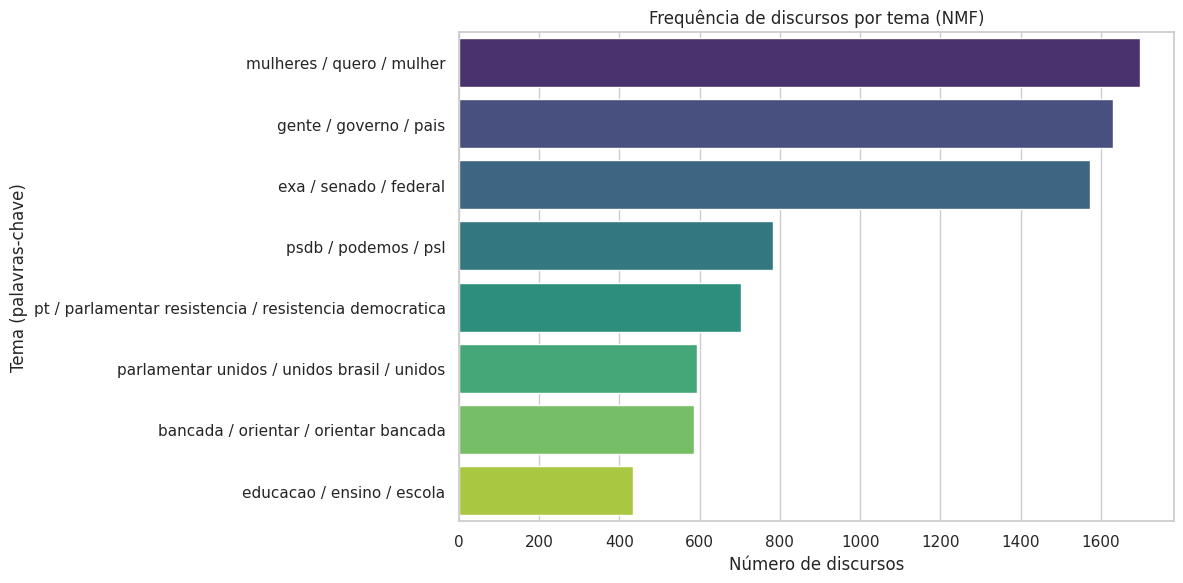

,tema_label,n_discursos
0,mulheres / quero / mulher,1697
1,gente / governo / pais,1631
2,exa / senado / federal,1572
3,psdb / podemos / psl,783
4,pt / parlamentar resistencia / resistencia dem...,704
5,parlamentar unidos / unidos brasil / unidos,594
6,bancada / orientar / orientar bancada,586
7,educacao / ensino / escola,433


In [11]:
contagem_temas = (
    df_temas['tema_label']
        .value_counts()
        .rename_axis('tema_label')
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(12, 6))
sns.barplot(data=contagem_temas, x='n_discursos', y='tema_label', hue='tema_label', palette='viridis', legend=False)
plt.title('Frequência de discursos por tema (NMF)')
plt.xlabel('Número de discursos')
plt.ylabel('Tema (palavras-chave)')
plt.tight_layout()
plt.show()

contagem_temas


## Analisar evolução temporal do interesse por tema

Acompanhamos como a participação relativa de cada tema varia mês a mês.


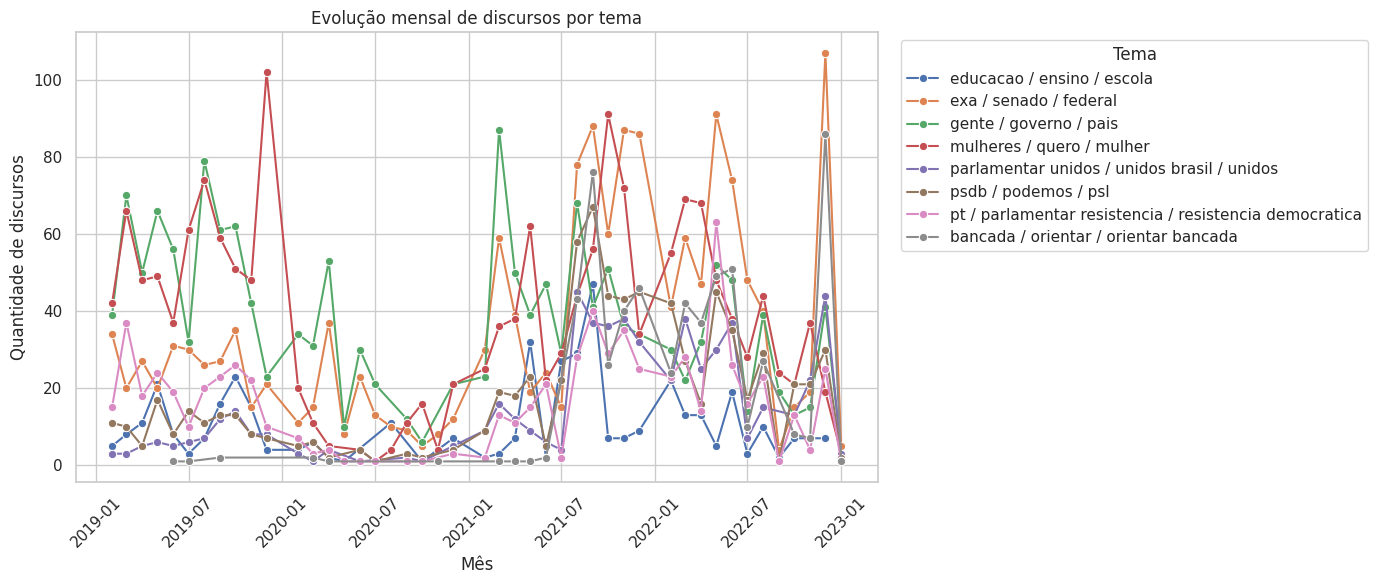

,mes,tema_label,n_discursos
0,2019-02-01,educacao / ensino / escola,5
1,2019-02-01,exa / senado / federal,34
2,2019-02-01,gente / governo / pais,39
3,2019-02-01,mulheres / quero / mulher,42
4,2019-02-01,parlamentar unidos / unidos brasil / unidos,3


In [12]:
df_temas['mes'] = df_temas['Data'].dt.to_period('M').dt.to_timestamp()
serie_temas = (
    df_temas.groupby(['mes', 'tema_label'])
        .size()
        .reset_index(name='n_discursos')
)

plt.figure(figsize=(14, 6))
sns.lineplot(data=serie_temas, x='mes', y='n_discursos', hue='tema_label', marker='o')
plt.title('Evolução mensal de discursos por tema')
plt.xlabel('Mês')
plt.ylabel('Quantidade de discursos')
plt.xticks(rotation=45)
plt.legend(title='Tema', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()

serie_temas.head()
